# Phase-vocoder

References:

https://www.guitarpitchshifter.com/algorithm.html

https://cmtext.indiana.edu/synthesis/chapter4_pv.php

https://cycling74.com/tutorials/the-phase-vocoder-%E2%80%93-part-i

https://librosa.org/doc/latest/index.html

## Задача

Есть цифровой сигнал звука. Мы хотим сжать/растянуть его по времени. Если сделать это наивно, просто удалив или интерполирововав промежуточные значения в цифровом сигнале, у звука изменится частота и соответственно высота - он будет звучать либо более высоким при сжатии, либо более низким при растяжении. 

Мы же хотим сохранить питч, поэтому в статье предлагается следующая идея - пройтись окном (aka свертка) по сигналу, сам сигнал растянуть, а затем просуммировать со сглаженной суммой всех окон, причем относительное положение окон меняется, чтобы совпасть с длинной сигнала.


![](https://www.guitarpitchshifter.com/fig_3_3.png)

Однако возникает проблема,  связанная с сильными различиями звука на стыке окон, что станет причиной возникновения слышимых звуковых гличей.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import librosa

from IPython.display import Audio

In [38]:
INPUT_FILE = './data/test_mono.wav'
OUTPUT_FILE = './data/test_mono_out.wav'

SAMPLING_RATE = 16000
BITRATE = 256
TIME_DURATION = 16

In [13]:
!ffprobe -hide_banner -i $INPUT_FILE # check sampling rate and other parameters

Input #0, wav, from './data/test_mono.wav':
  Metadata:
    artist          : Sound Clip
    date            : 2018
    genre           : Sound Clip
    title           : Sound_08129
    album           : Речи, обращения
    encoder         : Lavf58.29.100
  Duration: 00:00:16.80, bitrate: 256 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 16000 Hz, 1 channels, s16, 256 kb/s


In [15]:
def wav_to_mel_spectrogram(wav, sr, n_fft, hop_length, n_mels):
    D = librosa.stft(wav, n_fft=n_fft, hop_length=hop_length)
    S = librosa.feature.melspectrogram(S=np.abs(D), sr=sr, n_mels=n_mels)
    return S

In [16]:
# write a function to plot mel spectrogram
def plot_mel_spectrogram(mel_spectrogram, sr, hop_length, n_mels):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max),
                             y_axis='mel', fmax=sr/2, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

In [22]:
def display_sound(data):
    plt.figure(figsize=(10, 4))
    plt.plot(data)
    plt.title('График амплитуд')
    plt.tight_layout()
    plt.show()
    Audio(data, rate=SAMPLING_RATE)

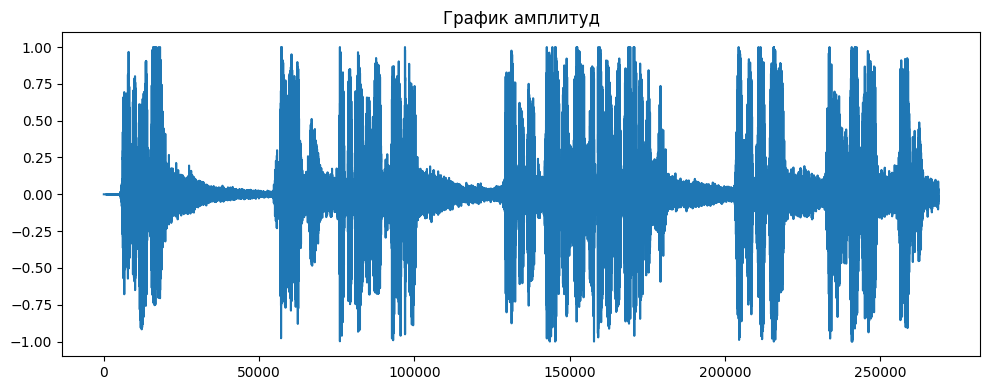

In [23]:
data, sr = librosa.load(INPUT_FILE, sr=16000)
display_sound(data)

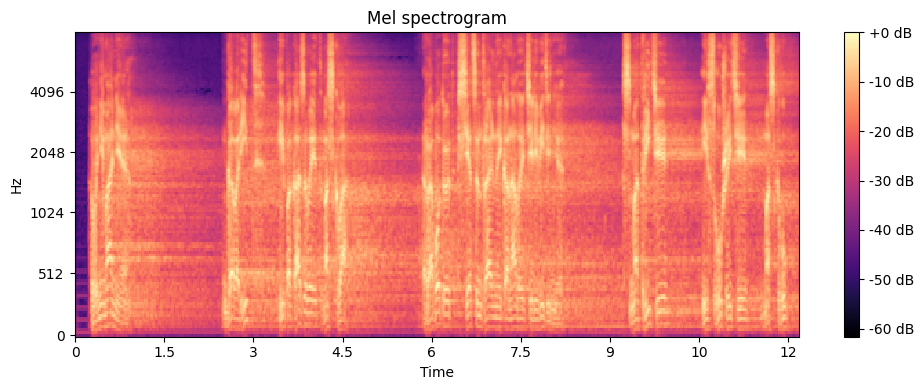

In [18]:
n_fft = 2048
hop_length = 512
n_mels = 128
mel_spectrogram = wav_to_mel_spectrogram(data, SAMPLING_RATE, n_fft, hop_length, n_mels)
plot_mel_spectrogram(mel_spectrogram, sr, hop_length, n_mels)

## Решение

In [ ]:
import math
from math import cos, pi
from scipy.fft import fft

def hanning_window(n, N):
    w = 0.5 * (1 - cos(2*pi*n / (N - 1)))
    return w

def process_signal(x: np.ndarray, sr:int,  frame_size: int, hop_size: int, N: int) -> np.ndarray:
    """Performs STFT by applying Hanning window
    
    ## Parameters:
    - x: np.ndarray - source digital signal
    - sr: int - sampling rate of signal
    - frame_size: int - size of single frame
    - hop_size: int - size of hop between frames, 1/hop_size = overlap
    - N: int - size of Hammon window

    ## Returns:
    X: np.ndarray - freq/t matrix
    """
    X = np.zeros((len(x) // frame_size))
    for i in range(len(X)):
        w = 2*pi*k*n # k - frequency bin
        X[i] += np.sum([x[i*hop_size + n]*hanning_window(n, N)*np.exp(j/N) for n in range(N)])


In [ ]:
N = 16 # size of window
hs = N // 4 # hop size

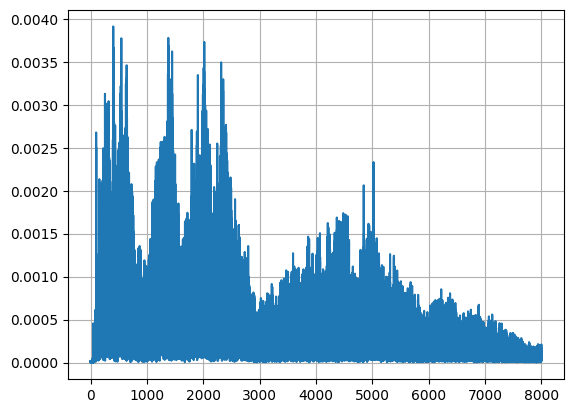

In [39]:


N = len(data) # number of sample points
T = 1/SAMPLING_RATE # sample spacing
yf = fft(data)
xf = fftfreq(N, T)[:N//2] # frequencies

plt.plot(xf, 2./N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()